# MCNPy MCTAL File Tutorial

This notebook demonstrates how to use the MCNPy library to read, analyze, and visualize MCNP MCTAL files. MCTAL (Monte Carlo Tally) files contain the tally results from MCNP simulations.

## Getting Started

First, let's import the necessary modules:

In [19]:
import mcnpy
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Loading a MCTAL File

We'll use a sample MCTAL file included in the MCNPy test data.

In [11]:
repo_root = Path.cwd().resolve().parent
mctalfile = repo_root / 'tests' / 'data' / 'mctal' / 'PWRSphere_F4_test.m'
print(f"Loading MCTAL file: {mctalfile}")

Loading MCTAL file: /home/MONLEON-JUAN/MCNPy/tests/data/mctal/PWRSphere_F4_test.m


Now we read the MCTAL file using `mcnpy.read_mctal()` function:

In [12]:
mctal = mcnpy.read_mctal(mctalfile)
print("MCTAL file successfully loaded!")

MCTAL file successfully loaded!


## Exploring the MCTAL File Structure

The `Mctal` class contains header information and tally data. Let's first look at the header information:

In [13]:
print(f"MCNP Code: {mctal.code_name} {mctal.ver}")
print(f"Problem ID: {mctal.probid}")
print(f"Number of particle histories (NPS): {mctal.nps:,}")
print(f"Problem description: {mctal.problem_id}")
print(f"Number of tallies: {mctal.ntal}")
print(f"Number of perturbations: {mctal.npert}")
print(f"\nAvailable tally numbers: {mctal.tally_numbers}")

MCNP Code: mcnp6 6
Problem ID: 02/22/25 15:50:25
Number of particle histories (NPS): 100,000
Problem description: attenuation Sphere for PWR
Number of tallies: 3
Number of perturbations: 0

Available tally numbers: [4, 14, 24]


## Accessing Tally Data

Tallies are stored in a dictionary within the `Mctal` object, keyed by tally number. Let's explore the first tally:

In [14]:
# Get the first tally number
first_tally_number = mctal.tally_numbers[0]
tally = mctal.tally[first_tally_number]

print(f"Tally ID: {tally.tally_id}")
print(f"Tally name: {tally.name}")

print("\nEnergy bin boundaries:")
for i, energy in enumerate(tally.energies):
    print(f"  Bin {i}: {energy} MeV")

print("\nNumber of results: ", len(tally.results))
print("First few results:")
for i in range(min(5, len(tally.results))):
    print(f"  Bin {i}: Result = {tally.results[i]:.6e}, Rel. Error = {tally.errors[i]:.6f}")

Tally ID: 4
Tally name: shell Detector

Energy bin boundaries:
  Bin 0: 0.1 MeV
  Bin 1: 1.0 MeV
  Bin 2: 3.0 MeV

Number of results:  3
First few results:
  Bin 0: Result = 2.958870e-09, Rel. Error = 0.103800
  Bin 1: Result = 8.254050e-09, Rel. Error = 0.076500
  Bin 2: Result = 8.621960e-10, Rel. Error = 0.193200


## Visualizing Tally Results

Let's create a plot of the tally results with error bars:

ValueError: 'x' and 'y' must have the same size

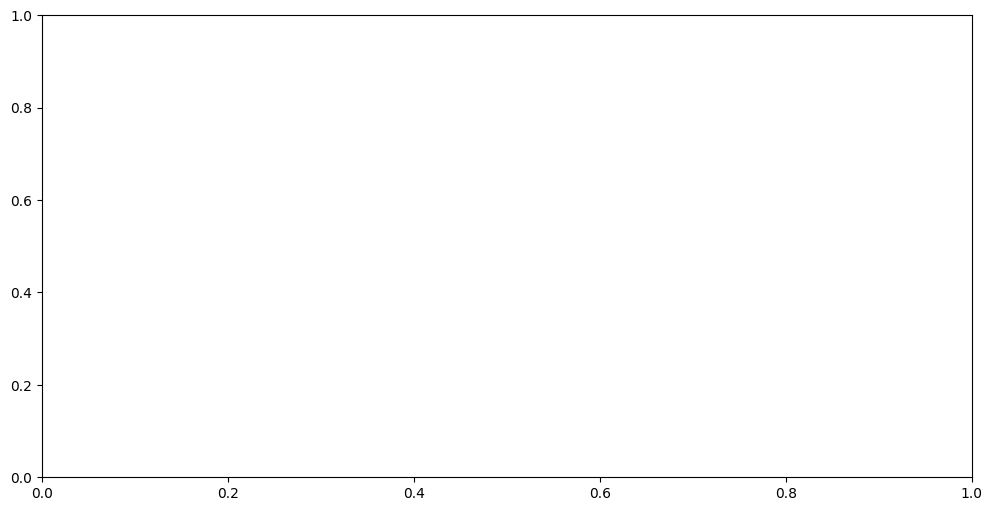

In [15]:
def plot_tally_results(tally):
    """Plot the results of a tally with error bars."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Get energy bin midpoints for plotting
    energy_mids = [(tally.energies[i] + tally.energies[i+1])/2 for i in range(len(tally.energies)-1)]
    
    # Calculate absolute errors from relative errors
    abs_errors = [result * error for result, error in zip(tally.results, tally.errors)]
    
    # Plot the results with error bars
    ax.errorbar(energy_mids, tally.results, yerr=abs_errors, fmt='o-', capsize=5, label='Tally results')
    
    # Add labels and title
    ax.set_xlabel('Energy (MeV)')
    ax.set_ylabel('Tally Result')
    ax.set_title(f'Tally {tally.tally_id} Results with Error Bars')
    ax.set_xscale('log')
    ax.grid(True, which="both", ls="-")
    
    plt.tight_layout()
    return fig

# Plot the results for the first tally
fig = plot_tally_results(tally)
plt.show()

## TFC (Tally Fluctuation Chart) Data

If TFC data is available, we can visualize the convergence of the tally using the built-in plotting method:

TFC data is available with 13 data points


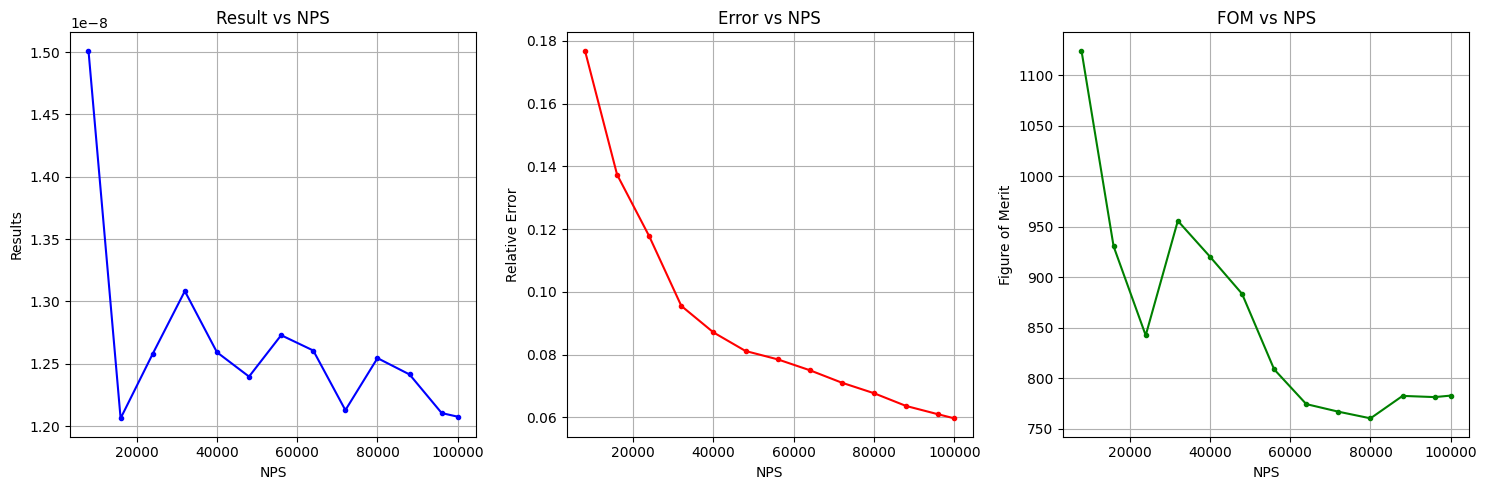

In [16]:
# Check if TFC data is available
if tally.tfc_nps:
    print(f"TFC data is available with {len(tally.tfc_nps)} data points")
    
    # Use the built-in plot_tfc_data method
    fig = tally.plot_tfc_data(figsize=(15, 5))
    plt.show()
else:
    print("No TFC data available for this tally.")
    
    # Simulate some TFC data for demonstration if none exists
    print("Creating sample TFC data for demonstration purposes...")
    
    # Simulate TFC data points
    tally.tfc_nps = [int(1e6 * i) for i in range(1, 11)]
    
    # Simulated results approach a final value
    final_value = 0.5
    noise = 0.1
    tally.tfc_results = [final_value * (1 - 0.5/i) + np.random.normal(0, noise/i) for i in range(1, 11)]
    
    # Errors typically decrease with 1/sqrt(N)
    tally.tfc_errors = [0.2 / np.sqrt(i) for i in range(1, 11)]
    
    # FOM is typically proportional to 1/(error²*time)
    tally.tfc_fom = [1.0 / (err*err*i) for i, err in enumerate(tally.tfc_errors, 1)]
    
    # Now plot the simulated data
    fig = tally.plot_tfc_data(figsize=(15, 5))
    plt.suptitle('Sample TFC Data (Demonstration Only)', fontsize=16, y=1.05)
    plt.show()

## Handling Perturbation Data

If the MCTAL file includes perturbation data, we can access it through the `pert_data` dictionary:

In [17]:
# Check if perturbation data is available
if tally.pert_data:
    print(f"Perturbation data is available with {len(tally.pert_data)} perturbations")
    
    # Display perturbation indices
    print(f"Perturbation indices: {list(tally.pert_data.keys())}")
    
    # Example: Compare base case with first perturbation
    first_pert_idx = list(tally.pert_data.keys())[0]
    pert_results = tally.pert_data[first_pert_idx].get('results', [])
    pert_errors = tally.pert_data[first_pert_idx].get('errors', [])
    
    if pert_results and len(pert_results) == len(tally.results):
        # Plot comparison
        fig, ax = plt.subplots(figsize=(12, 6))
        energy_mids = [(tally.energies[i] + tally.energies[i+1])/2 for i in range(len(tally.energies)-1)]
        
        ax.plot(energy_mids, tally.results, 'o-', label='Base case')
        ax.plot(energy_mids, pert_results, 's-', label=f'Perturbation {first_pert_idx}')
        
        ax.set_xlabel('Energy (MeV)')
        ax.set_ylabel('Tally Result')
        ax.set_title('Comparison of Base Case and Perturbed Results')
        ax.set_xscale('log')
        ax.legend()
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Perturbation data format doesn't match base case for plotting")
else:
    print("No perturbation data available in this MCTAL file.")

No perturbation data available in this MCTAL file.


## Working with Multiple Tallies

If the MCTAL file contains multiple tallies, we can iterate through them:

In [18]:
if len(mctal.tally_numbers) > 1:
    print(f"This MCTAL file contains {len(mctal.tally_numbers)} tallies.")
    
    # Print summary of all tallies
    print("\nTally Summary:")
    print("-" * 60)
    print(f"{'Tally ID':^10} | {'Name':^20} | {'# of Bins':^10} | {'Integral Result':^15}")
    print("-" * 60)
    
    for tally_id in mctal.tally_numbers:
        tally_obj = mctal.tally[tally_id]
        name = tally_obj.name if tally_obj.name else "<unnamed>"
        num_bins = len(tally_obj.results)
        integral = tally_obj.integral_result if tally_obj.integral_result is not None else "N/A"
        
        print(f"{tally_id:^10} | {name[:20]:^20} | {num_bins:^10} | {integral:^15}")
else:
    print("This MCTAL file contains only one tally.")

This MCTAL file contains 3 tallies.

Tally Summary:
------------------------------------------------------------
 Tally ID  |         Name         | # of Bins  | Integral Result
------------------------------------------------------------
    4      |    shell Detector    |     3      |   1.20751e-08  
    14     |      test Tally      |     1      |   1.35263e-05  
    24     |      <unnamed>       |     1      |   1.01427e-06  


## Summary

In this tutorial, we've learned how to:

1. Load a MCTAL file using MCNPy
2. Access header information and tally data
3. Visualize tally results with error bars
4. Plot TFC data to assess tally convergence
5. Work with perturbation data if available
6. Handle multiple tallies in a single MCTAL file

These tools provide a powerful way to analyze MCNP simulation results directly in Python, without the need for manual parsing of the MCTAL files.